In [17]:
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, LeakyReLU, ELU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
import os

In [2]:
# 1. Definir índices de trastornos

NUM_PREGUNTAS = 25 
NUM_TRASTORNOS = 5
PREGUNTAS_POR_TRASTORNO = 5

# Nombres de las clases para referencia
clases = [
    'Trastorno Depresivo Mayor',
    'Trastorno de Ansiedad Generalizada',
    'Trastorno de Ansiedad Social',
    'Trastorno por Déficit de Atención',
    'Trastorno Antisocial de la Personalidad'
]
# Definir los índices correspondientes a las preguntas de cada trastorno
indices_trastornos = [
    range(0, 5),   # Preguntas para Trastorno Depresivo Mayor
    range(5, 10),  # Preguntas para Trastorno de Ansiedad Generalizada
    range(10, 15), # Preguntas para Trastorno de Ansiedad Social
    range(15, 20), # Preguntas para Trastorno por Déficit de Atención
    range(20, 25)  # Preguntas para Trastorno Antisocial de la Personalidad
]

In [3]:
# 2. Funciones de generación de casos

def generar_caso_unico_trastorno(trastorno_id):
    """
    Genera un caso con un solo trastorno específico.
    
    Parámetros:
    - trastorno_id: Índice del trastorno (0 a 4).
    
    Retorna:
    - X: Vector de respuestas (numpy array de 25 elementos).
    - Y: Vector de etiquetas (numpy array de 5 elementos, float).
    """
    X = np.zeros(NUM_PREGUNTAS, dtype=int)
    Y = np.zeros(NUM_TRASTORNOS, dtype=float)
    for idx in indices_trastornos[trastorno_id]:
        X[idx] = 4  # Máxima puntuación (0 a 4)
    Y[trastorno_id] = 1.0  # Asignar como float
    return X, Y

def generar_caso_multiple_trastornos(trastorno_ids):
    """
    Genera un caso con múltiples trastornos.
    
    Parámetros:
    - trastorno_ids: Lista de índices de trastornos (ej. [0, 2]).
    
    Retorna:
    - X: Vector de respuestas (numpy array de 25 elementos).
    - Y: Vector de etiquetas (numpy array de 5 elementos, float).
    """
    X = np.zeros(NUM_PREGUNTAS, dtype=int)
    Y = np.zeros(NUM_TRASTORNOS, dtype=float)
    for trastorno_id in trastorno_ids:
        for idx in indices_trastornos[trastorno_id]:
            X[idx] = 4  # Máxima puntuación (0 a 4)
        Y[trastorno_id] = 1.0  # Asignar como float
    return X, Y

def generar_caso_unico_trastorno_con_ruido(trastorno_id, ruido_min=0, ruido_max=3):
    """
    Genera un caso con un solo trastorno y ruido en las demás respuestas.
    
    Parámetros:
    - trastorno_id: Índice del trastorno (0 a 4).
    - ruido_min: Valor mínimo de ruido.
    - ruido_max: Valor máximo de ruido.
    
    Retorna:
    - X: Vector de respuestas (numpy array de 25 elementos).
    - Y: Vector de etiquetas (numpy array de 5 elementos, float).
    """
    X = np.zeros(NUM_PREGUNTAS, dtype=int)
    Y = np.zeros(NUM_TRASTORNOS, dtype=float)
    for idx in indices_trastornos[trastorno_id]:
        X[idx] = 4  # Máxima puntuación
    Y[trastorno_id] = 1.0
    for i in range(NUM_PREGUNTAS):
        if i not in indices_trastornos[trastorno_id]:
            X[i] = np.random.randint(ruido_min, ruido_max + 1)
    return X, Y

def generar_caso_multiple_trastornos_con_ruido(trastorno_ids, ruido_min=0, ruido_max=3):
    """
    Genera un caso con múltiples trastornos y ruido en las demás respuestas.
    
    Parámetros:
    - trastorno_ids: Lista de índices de trastornos (ej. [0, 2]).
    - ruido_min: Valor mínimo de ruido.
    - ruido_max: Valor máximo de ruido.
    
    Retorna:
    - X: Vector de respuestas (numpy array de 25 elementos).
    - Y: Vector de etiquetas (numpy array de 5 elementos, float).
    """
    X = np.zeros(NUM_PREGUNTAS, dtype=int)
    Y = np.zeros(NUM_TRASTORNOS, dtype=float)
    trastornos_indices = set()
    for trastorno_id in trastorno_ids:
        for idx in indices_trastornos[trastorno_id]:
            X[idx] = 4  # Máxima puntuación
            trastornos_indices.add(idx)
        Y[trastorno_id] = 1.0
    for i in range(NUM_PREGUNTAS):
        if i not in trastornos_indices:
            X[i] = np.random.randint(ruido_min, ruido_max + 1)
    return X, Y

def calcular_etiquetas(X):
    """
    Calcula las etiquetas (Y) basándose en las respuestas (X).
    
    Parámetros:
    - X: Vector de respuestas (numpy array de 25 elementos).
    
    Retorna:
    - Y: Vector de etiquetas (numpy array de 5 elementos, float).
    """
    Y = np.zeros(NUM_TRASTORNOS, dtype=float)
    for i, indices in enumerate(indices_trastornos):
        suma = X[list(indices)].sum()
        max_val = len(indices) * 4
        porcentaje = suma / max_val
        if porcentaje == 1.0:
            Y[i] = 1.0
        else:
            Y[i] = round(porcentaje, 3)
    return Y

def generar_caso_mixto_sin_trastornos(ruido_min=0, ruido_max=3):
    """
    Genera un caso mixto sin trastornos predominantes, con ruido.
    
    Parámetros:
    - ruido_min: Valor mínimo de ruido.
    - ruido_max: Valor máximo de ruido.
    
    Retorna:
    - X: Vector de respuestas (numpy array de 25 elementos).
    - Y: Vector de etiquetas (numpy array de 5 elementos, float).
    """
    X = np.zeros(NUM_PREGUNTAS, dtype=int)
    for i in range(NUM_PREGUNTAS):
        prob_4 = 0.05  # 5% probabilidad de ser 4
        if random.random() < prob_4:
            X[i] = 4
        else:
            X[i] = np.random.randint(ruido_min, ruido_max + 1)
    Y = calcular_etiquetas(X)
    return X, Y

# --- Nuevas Funciones Añadidas ---

def generar_caso_uniforme(valor):
    """
    Genera un caso donde todas las respuestas en X tienen el mismo valor.
    
    Parámetros:
    - valor: Valor a asignar a todas las respuestas en X (0, 1, 2, 3, 4).
    
    Retorna:
    - X: Vector de respuestas (numpy array de 25 elementos).
    - Y: Vector de etiquetas (numpy array de 5 elementos, float).
    """
    X = np.full(NUM_PREGUNTAS, valor, dtype=int)
    if valor == 0:
        Y = np.zeros(NUM_TRASTORNOS, dtype=float)
    else:
        Y = calcular_etiquetas(X)
    return X, Y

# --- Fin de Nuevas Funciones ---

def generar_conjunto_de_datos(total_muestras=10000):
    """
    Genera un conjunto de datos balanceado con diferentes tipos de casos, incluyendo casos uniformes.
    
    Parámetros:
    - total_muestras: Número total de muestras a generar.
    
    Retorna:
    - X: Matriz de respuestas (numpy array de forma [total_muestras, 25]).
    - Y: Matriz de etiquetas (numpy array de forma [total_muestras, 5]).
    """
    X_list = []
    Y_list = []
    
    # Definir tipos de casos
    tipos_casos = [
        'unico_trastorno',
        'multiple_trastornos',
        'unico_trastorno_con_ruido',
        'multiple_trastornos_con_ruido',
        'mixto_sin_trastornos',
        'uniforme_0',
        'uniforme_1',
        'uniforme_2',
        'uniforme_3',
        'uniforme_4'
    ]
    
    muestras_por_tipo = total_muestras // len(tipos_casos)  # 10% para cada tipo
    
    # 1. Casos con un solo trastorno
    for trastorno_id in range(NUM_TRASTORNOS):
        for _ in range(muestras_por_tipo // NUM_TRASTORNOS):
            X, Y = generar_caso_unico_trastorno(trastorno_id)
            X_list.append(X)
            Y_list.append(Y)
    # Ajustar en caso de resto
    resto = muestras_por_tipo - ( (muestras_por_tipo // NUM_TRASTORNOS) * NUM_TRASTORNOS )
    for _ in range(resto):
        trastorno_id = random.randint(0, NUM_TRASTORNOS - 1)
        X, Y = generar_caso_unico_trastorno(trastorno_id)
        X_list.append(X)
        Y_list.append(Y)
    
    # 2. Casos con múltiples trastornos
    for _ in range(muestras_por_tipo):
        num_trastornos = np.random.randint(2, NUM_TRASTORNOS + 1)
        trastorno_ids = random.sample(range(NUM_TRASTORNOS), num_trastornos)
        X, Y = generar_caso_multiple_trastornos(trastorno_ids)
        X_list.append(X)
        Y_list.append(Y)
    
    # 3. Casos con un trastorno y ruido
    for trastorno_id in range(NUM_TRASTORNOS):
        for _ in range(muestras_por_tipo // NUM_TRASTORNOS):
            X, Y = generar_caso_unico_trastorno_con_ruido(trastorno_id)
            X_list.append(X)
            Y_list.append(Y)
    # Ajustar en caso de resto
    resto = muestras_por_tipo - ( (muestras_por_tipo // NUM_TRASTORNOS) * NUM_TRASTORNOS )
    for _ in range(resto):
        trastorno_id = random.randint(0, NUM_TRASTORNOS - 1)
        X, Y = generar_caso_unico_trastorno_con_ruido(trastorno_id)
        X_list.append(X)
        Y_list.append(Y)
    
    # 4. Casos con múltiples trastornos y ruido
    for _ in range(muestras_por_tipo):
        num_trastornos = np.random.randint(2, NUM_TRASTORNOS + 1)
        trastorno_ids = random.sample(range(NUM_TRASTORNOS), num_trastornos)
        X, Y = generar_caso_multiple_trastornos_con_ruido(trastorno_ids)
        X_list.append(X)
        Y_list.append(Y)
    
    # 5. Casos mixtos sin trastornos claros
    for _ in range(2*muestras_por_tipo):
        X, Y = generar_caso_mixto_sin_trastornos()
        X_list.append(X)
        Y_list.append(Y)
    
    # 6-10. Casos uniformes
    
    # 6. Todos los X = 0
    for _ in range(muestras_por_tipo):
        X, Y = generar_caso_uniforme(0)
        X_list.append(X)
        Y_list.append(Y)
    # Un caso doble
    for _ in range(muestras_por_tipo):
        X, Y = generar_caso_uniforme(0)
        X_list.append(X)
        Y_list.append(Y)
    
    
    # 7. Todos los X = 1
    for _ in range(muestras_por_tipo):
        X, Y = generar_caso_uniforme(1)
        X_list.append(X)
        Y_list.append(Y)
    # Un caso doble
    for _ in range(muestras_por_tipo):
        X, Y = generar_caso_uniforme(1)
        X_list.append(X)
        Y_list.append(Y)
    
    
    # 8. Todos los X = 2
    for _ in range(muestras_por_tipo):
        X, Y = generar_caso_uniforme(2)
        X_list.append(X)
        Y_list.append(Y)
    # Un caso doble
    for _ in range(muestras_por_tipo):
        X, Y = generar_caso_uniforme(2)
        X_list.append(X)
        Y_list.append(Y)
    
    
    # 9. Todos los X = 3
    for _ in range(muestras_por_tipo):
        X, Y = generar_caso_uniforme(3)
        X_list.append(X)
        Y_list.append(Y)
    # Un caso doble
    for _ in range(muestras_por_tipo):
        X, Y = generar_caso_uniforme(3)
        X_list.append(X)
        Y_list.append(Y)
    
    
    # 10. Todos los X = 4
    for _ in range(muestras_por_tipo):
        X, Y = generar_caso_uniforme(4)
        X_list.append(X)
        Y_list.append(Y)
    # Un caso doble
    for _ in range(muestras_por_tipo):
        X, Y = generar_caso_uniforme(4)
        X_list.append(X)
        Y_list.append(Y)
    
    # Convertir listas a arrays de numpy
    X = np.array(X_list)
    Y = np.array(Y_list)
        
    return X, Y

In [4]:
def verificar_valores_Y(X, Y, muestra=0):
    """
    Verifica los valores de Y para una muestra específica.
    
    Parámetros:
    - X: Matriz de respuestas (numpy array de forma [total_muestras, 25]).
    - Y: Matriz de etiquetas (numpy array de forma [total_muestras, 5]).
    - muestra: Índice de la muestra a verificar.
    """
    print(f"\n=== Verificación de la muestra {muestra} ===")
    print("Respuestas (X):", X[muestra])
    print("Etiquetas (Y):", Y[muestra])
    for i, valor in enumerate(Y[muestra]):
        print(f"{clases[i]}: {valor:.2f}")

# Generar un pequeño conjunto de datos para prueba
# X_test, Y_test = generar_conjunto_de_datos(total_muestras=10)

# # Verificar cada muestra
# for i in range(10):
#     verificar_valores_Y(X_test, Y_test, muestra=i)

In [5]:
# 3. Generación y Verificación del Conjunto de Datos
X, Y = generar_conjunto_de_datos(total_muestras=80000)

np.savetxt(os.path.join('../ia3/datos/', 'X.txt'), X, fmt='%d')
np.savetxt(os.path.join('../ia3/datos/', 'Y.txt'), Y, fmt='%.3f')

# Verificar la distribución de etiquetas
df_Y = pd.DataFrame(Y, columns=clases)
print("Distribución de etiquetas:")
print(df_Y.sum())

Distribución de etiquetas:
Trastorno Depresivo Mayor                  60904.50
Trastorno de Ansiedad Generalizada         60869.45
Trastorno de Ansiedad Social               60833.20
Trastorno por Déficit de Atención          60845.55
Trastorno Antisocial de la Personalidad    60895.05
dtype: float64


In [6]:
# 4. Escalar los Datos de Entrada
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
# 5. División en Entrenamiento y Validación
X_train, X_val, Y_train, Y_val = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

In [23]:
# 6. Construcción del Modelo

def crear_modelo():
    modelo = Sequential()
    
    modelo.add(Input(shape=(25,)))
    
    modelo.add(Dense(375, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    # modelo.add(Dense(250, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
    # modelo.add(BatchNormalization())
    modelo.add(ELU())
    modelo.add(Dropout(0.4))
    
    modelo.add(Dense(250, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    # modelo.add(Dense(125, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
    # modelo.add(BatchNormalization())
    modelo.add(ELU())
    modelo.add(Dropout(0.5))
    
    modelo.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    # modelo.add(Dense(75, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
    # modelo.add(BatchNormalization())
    modelo.add(ELU())
    modelo.add(Dropout(0.3))
    
    modelo.add(Dense(5, activation='sigmoid'))
    
    modelo.compile(optimizer=Adam(learning_rate=0.001),
            #    loss='mean_squared_error',  # MSE para regresión
               loss=Huber(),  # MSE para regresión
               metrics=['mean_squared_error', 'mean_absolute_error', 'precision'])
    return modelo

# Crear el modelo
modelo = crear_modelo()
# modelo.summary()

In [24]:
# 7. Entrenamiento del Modelo
early_stop = EarlyStopping(
        monitor='val_loss', 
        patience=7, 
        restore_best_weights=True
    )

reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.4,
        patience=4,
        min_lr=1e-5,
        verbose=1
    )
    
history = modelo.fit(X_train, Y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, Y_val),
                    callbacks=[early_stop, reduce_lr],
                    verbose=1)

Epoch 1/200
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0653 - mean_absolute_error: 0.1638 - mean_squared_error: 0.0516 - precision: 0.9226 - val_loss: 0.0231 - val_mean_absolute_error: 0.1061 - val_mean_squared_error: 0.0310 - val_precision: 0.9418 - learning_rate: 0.0010
Epoch 2/200
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0254 - mean_absolute_error: 0.1268 - mean_squared_error: 0.0356 - precision: 0.9507 - val_loss: 0.0214 - val_mean_absolute_error: 0.1037 - val_mean_squared_error: 0.0273 - val_precision: 0.9692 - learning_rate: 0.0010
Epoch 3/200
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0228 - mean_absolute_error: 0.1095 - mean_squared_error: 0.0286 - precision: 0.9676 - val_loss: 0.0173 - val_mean_absolute_error: 0.0788 - val_mean_squared_error: 0.0164 - val_precision: 0.9840 - learning_rate: 0.0010
Epoch 4/200
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0193 - mean_absolute_error: 0.0929 - mean_squared_error: 0.0204 - precision: 0.9848 - 

KeyboardInterrupt: 

In [13]:
# 8. Evaluación del Modelo

# Evaluar el modelo con Keras Metrics
loss, mse, mae, precision = modelo.evaluate(X_val, Y_val, verbose=0)

# Imprimir resultados de evaluación de Keras
print(f"\nTest Loss (MSE): {loss:.4f}")
print(f"Test Mean Squared Error (MSE): {mse:.4f}")
print(f"Test Mean Absolute Error (MAE): {mae:.4f}")
print(f"Test Precision: {precision:.4f}")

# Predicciones en el conjunto de validación
Y_pred = modelo.predict(X_val)

# Cálculo de métricas adicionales con scikit-learn
mse_sklearn = mean_squared_error(Y_val, Y_pred)
mae_sklearn = mean_absolute_error(Y_val, Y_pred)
r2 = r2_score(Y_val, Y_pred)

# Imprimir métricas adicionales
print(f"\nMean Squared Error (sklearn): {mse_sklearn:.4f}")
print(f"Mean Absolute Error (sklearn): {mae_sklearn:.4f}")
print(f"R² Score (sklearn): {r2:.4f}")


Test Loss (MSE): 0.0001
Test Mean Squared Error (MSE): 0.0001
Test Mean Absolute Error (MAE): 0.0034
Test Precision: 1.0000
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 704us/step

Mean Squared Error (sklearn): 0.0001
Mean Absolute Error (sklearn): 0.0034
R² Score (sklearn): 0.9990


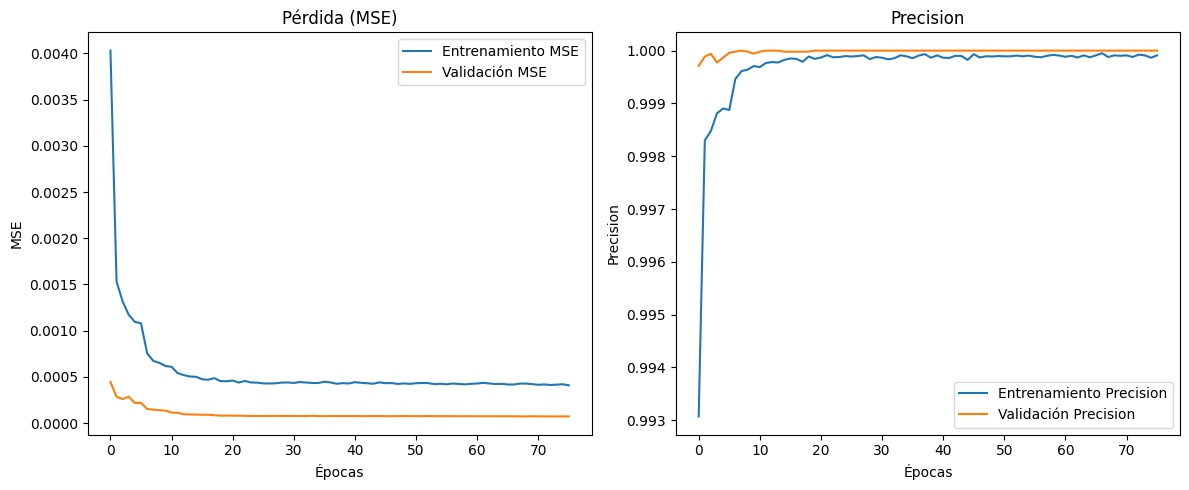

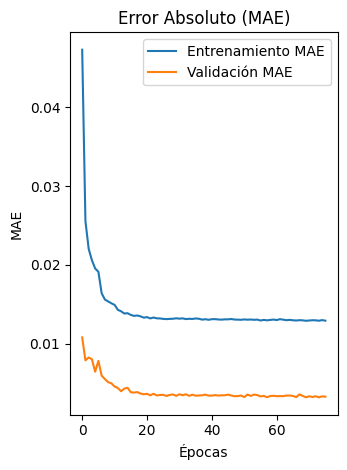

In [14]:
# 9. Visualización de las Métricas de Entrenamiento
def graficar_historial(history):
    plt.figure(figsize=(12, 5))
    
    # Pérdida (MSE)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Entrenamiento MSE')
    plt.plot(history.history['val_loss'], label='Validación MSE')
    plt.title('Pérdida (MSE)')
    plt.xlabel('Épocas')
    plt.ylabel('MSE')
    plt.legend()
    
    # Error Absoluto (MAE)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['precision'], label='Entrenamiento Precision')
    plt.plot(history.history['val_precision'], label='Validación Precision')
    plt.title('Precision')
    plt.xlabel('Épocas')
    plt.ylabel('Precision')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_absolute_error'], label='Entrenamiento MAE')
    plt.plot(history.history['val_mean_absolute_error'], label='Validación MAE')
    plt.title('Error Absoluto (MAE)')
    plt.xlabel('Épocas')
    plt.ylabel('MAE')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


graficar_historial(history)

In [15]:
# 10. Guardar el Modelo y el Escalador

# Guardar el modelo entrenado en formato HDF5
modelo.save('../ia3/model/modelo_trastornos_cognitivos_huber.keras')
print("\nModelo guardado exitosamente en 'modelo_trastornos_cognitivos.keras'")

# Guardar el escalador utilizando joblib
joblib.dump(scaler, '../ia3/scaler/scaler_trastornos_cognitivos_huber.joblib')
print("Escalador guardado exitosamente en 'scaler_trastornos_cognitivos.joblib'")


Modelo guardado exitosamente en 'modelo_trastornos_cognitivos.keras'
Escalador guardado exitosamente en 'scaler_trastornos_cognitivos.joblib'
